# SNRCat vs. Green's SNR catalog

This is a quick check on SNR positions and extensions from:

* SNRCat [webpage](http://www.physics.umanitoba.ca/snr/SNRcat/)
* Green's SNR catalog
  [webpage](https://www.mrao.cam.ac.uk/surveys/snrs/),
  [vizier](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=VII/272)

## Some setup

We can get the Green and (soon) SNRCat as an Astropy table via gammapy.datasets:

* https://gammapy.readthedocs.org/en/latest/api/gammapy.datasets.load_catalog_green.html
* https://github.com/gammapy/gammapy/pull/262

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gammapy.datasets import load_catalog_green, load_catalog_snrcat

In [2]:
green = load_catalog_green()
print(green.colnames)

['Source_Name', 'RAJ2000', 'DEJ2000', 'GLON', 'GLAT', 'Dmean', 'Dmaj', 'Dmin', 'u_Dmin', 'l_S_1GHz_', 'S_1GHz_', 'u_S_1GHz_', 'alpha', 'u_alpha', 'type', 'Names']


In [3]:
snrcat = load_catalog_snrcat(cache=False)
print(snrcat.colnames)

['Source_Name', 'GLON', 'GLAT', 'Source_JName', 'J_ra', 'J_dec', 'DEJ2000', 'RAJ2000', 'id_uncertain', 'id_alt', 'id_old', 'type', 'type_uncertain', 'context', 'remnant', 'SN_year', 'SN_association', 'age_min', 'age_max', 'distance_min', 'distance_max', 'distance', 'size_radio', 'size_X']


## Is Green a subset of SNRCat?

Yes it is, all OK.

In [4]:
print(len(green))

294


In [5]:
print(len(snrcat))

378


In [6]:
set(green['Source_Name']).issubset(snrcat['Source_Name'])

True

## Join catalogs

In order to be able to do checks we need to join the two catalogs.

We do an inner join, i.e. the output table will only contain the SNRs that are in both catalogs.

In [7]:
from astropy.table import join as table_join
def tag_colnames(table, label):
    table = table.copy()
    for colname in table.colnames[1:]:
        table.rename_column(colname, label + '_' + colname)
    return table

cat = table_join(tag_colnames(green, 'Green'),
                 tag_colnames(snrcat, 'SNRCat')
                )
print(len(cat))
print(cat.colnames)

294
['Source_Name', 'Green_RAJ2000', 'Green_DEJ2000', 'Green_GLON', 'Green_GLAT', 'Green_Dmean', 'Green_Dmaj', 'Green_Dmin', 'Green_u_Dmin', 'Green_l_S_1GHz_', 'Green_S_1GHz_', 'Green_u_S_1GHz_', 'Green_alpha', 'Green_u_alpha', 'Green_type', 'Green_Names', 'SNRCat_GLON', 'SNRCat_GLAT', 'SNRCat_Source_JName', 'SNRCat_J_ra', 'SNRCat_J_dec', 'SNRCat_DEJ2000', 'SNRCat_RAJ2000', 'SNRCat_id_uncertain', 'SNRCat_id_alt', 'SNRCat_id_old', 'SNRCat_type', 'SNRCat_type_uncertain', 'SNRCat_context', 'SNRCat_remnant', 'SNRCat_SN_year', 'SNRCat_SN_association', 'SNRCat_age_min', 'SNRCat_age_max', 'SNRCat_distance_min', 'SNRCat_distance_max', 'SNRCat_distance', 'SNRCat_size_radio', 'SNRCat_size_X']


## Position check

Most SNR positions are inconsistent at the 0 to 0.1 deg level.
There's ~10 SNR with very inconsistent positions.

I didn't check yet what the cause is ...

In [8]:
from astropy.coordinates import SkyCoord
pos_green = SkyCoord(cat['Green_RAJ2000'], cat['Green_DEJ2000'], unit='deg', frame='icrs')
pos_snrcat = SkyCoord(cat['SNRCat_RAJ2000'], cat['SNRCat_DEJ2000'], unit='deg', frame='icrs')
cat['separation'] = pos_green.separation(pos_snrcat)
cat.sort('separation')
cat[-10:][['Source_Name', 'separation', 'Green_RAJ2000', 'SNRCat_RAJ2000',
           'Green_DEJ2000', 'SNRCat_DEJ2000']]

Source_Name,separation,Green_RAJ2000,SNRCat_RAJ2000,Green_DEJ2000,SNRCat_DEJ2000
,deg,deg,deg,deg,deg
str352,float64,float64,float64,float64,float64
G039.7-02.0,0.379263790658,288.0833,287.75,4.9167,5.1
G279.0+01.1,0.381962974564,149.4167,149.775,-53.25,-53.5666666667
G213.0-00.6,0.395157927958,102.7083,102.35,-0.5,-0.333333333333
G160.9+02.6,0.502641421831,75.25,75.45,46.6667,46.1833333333
G330.0+15.0,0.561712677365,227.5,228.075,-40.0,-40.35
G350.1-00.3,0.66198355093,259.4167,260.25,-37.4,-37.4
G358.1+00.1,0.933542573811,264.25,265.15,-29.9833,-30.5
G113.0+00.2,1.16013541419,354.1458,351.725,61.3667,61.4166666667


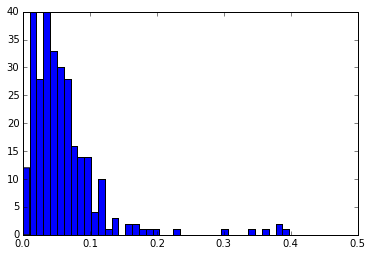

In [9]:
plt.hist(cat['separation'], bins=np.linspace(0, 0.5, 50));

Green's catalog only contains RA, DEC position: http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=VII/272
I compute the GLON, GLAT position with Astropy, so by definition they are consistent: https://github.com/gammapy/gammapy-extra/blob/master/datasets/catalogs/make_green.py

The SNRCat (RA, DEC) position is inconsistent with the (GLON, GLAT) position at the 0 to 0.02 deg level. 

Probably the reason is that positions aren't stored with enough digits?

This should be fixed, i.e. GLON, GLAT made consistent with RA, DEC.
If this is not desired for some reason, either GLON, GLAT or RA, DEC should be removed (keep the more accurate one if there is such a thing), leaving the computation of the other up to the user (e.g. using TOPCAT or Astropy).

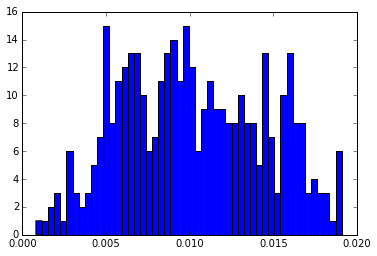

In [10]:
pos_icrs = SkyCoord(snrcat['RAJ2000'], snrcat['DEJ2000'], unit='deg', frame='icrs')
pos_galactic = SkyCoord(snrcat['GLON'], snrcat['GLAT'], unit='deg', frame='galactic')
separation = pos_icrs.separation(pos_galactic)
plt.hist(separation, bins=50);

## Extension check

For HGPS we currently plan to represent radio SNRs as circles for association and on sky images, probably with diameter = geometric mean of major and minor diameter in case of elongated SNRs.

Here's a check comparing these SNR diameters from Green against SNRCat.

For now we have to parse the extension text field from SNRCat ... hopefully they will add float columns in the future so that this is not necessary.

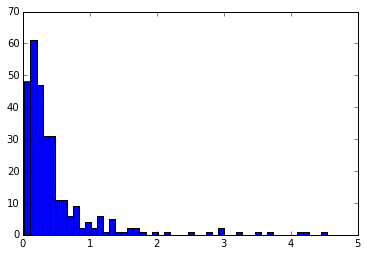

In [11]:
cat['Green_Dmean'] = cat['Green_Dmean'] / 60. # in degree
plt.hist(cat['Green_Dmean'], bins=50);

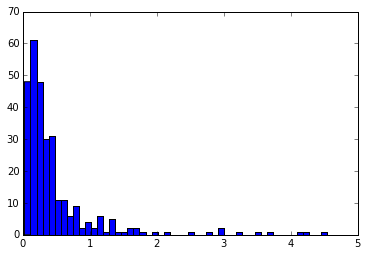

In [12]:
def compute_mean_diameter(d_major, d_minor):
    """Compute geometric mean diameter (preserves area)"""
    diameter = np.sqrt(d_major * d_minor)
    # If no `d_minor` is given, use `d_major` as mean radius
    with np.errstate(invalid='ignore'):
        diameter = np.where(d_minor > 0, diameter, d_major)

    return diameter

def compute_snrcat_diameter(text_col):
    from astropy.coordinates import Angle
    d_mean = []
    for text in text_col:
        # Parse this text field:
        if 'x' in text:
            a, b = text.split('x')
            d_major = Angle(a).deg
            d_minor = Angle(b).deg
        else:
            d_major = Angle(text).deg
            d_minor = d_major
        d_mean.append(compute_mean_diameter(d_major, d_minor))

    return d_mean

cat['SNRCat_Dmean'] = compute_snrcat_diameter(cat['SNRCat_size_radio'])
plt.hist(cat['SNRCat_Dmean'], bins=50);

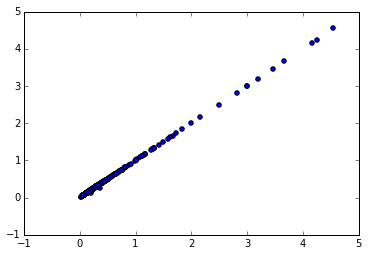

In [13]:
plt.scatter(cat['Green_Dmean'], cat['SNRCat_Dmean'])

In [14]:
# There's only two SNRs that are different: G054.1+00.3 and G065.7+01.2
# Otherwise the extensions are identical
cat['d_abs'] = cat['Green_Dmean'] - cat['SNRCat_Dmean']
cat.sort('d_abs')
cat[-10:][['Source_Name', 'd_abs', 'Green_Dmean', 'SNRCat_Dmean',
           'SNRCat_size_radio', 'Green_Dmaj', 'Green_Dmin']]

Source_Name,d_abs,Green_Dmean,SNRCat_Dmean,SNRCat_size_radio,Green_Dmaj,Green_Dmin
,arcmin,arcmin,,,arcmin,arcmin
str352,float64,float32,float64,str544,float32,float32
G156.2+05.7,3.97364299243e-08,1.83333,1.83333333333,110',110.0,nan
G093.7-00.2,3.97364299243e-08,1.33333,1.33333333333,80',80.0,nan
G279.0+01.1,3.97364299243e-08,1.58333,1.58333333333,95',95.0,nan
G347.3-00.5,4.2362348962e-08,0.996522,0.996521728592,65'x55',65.0,55.0
G082.2+05.3,4.68043008794e-08,1.30969,1.30968613713,95'x65',95.0,65.0
G261.9+05.5,4.9242228517e-08,0.57735,0.57735026919,40'x30',40.0,30.0
G205.5+00.5,7.94728598486e-08,3.66667,3.66666666667,220',220.0,nan
G116.5+01.1,9.8484457034e-08,1.1547,1.15470053838,80'x60',80.0,60.0
